Training Efficient-net B5 model on 104-Flowers + Extra tf-flower-dataset [found here](https://www.kaggle.com/kirillblinov/tf-flower-photo-tfrec) on TPU with Tensorflow.

**Common Settings**
* Augumentations: Cutmix+Mixup, Rotation Auguments + Some Tf-image transformations.
* 30 epochs, Batch_size 256, Image-size 512.
* Lr-schedule: Cosine Annealing.

**Previous Runs**

* FirstRun For 10 Epochs, categorical_accuracy: 0.8287, loss: 0.9035, lb: 0.96407
* SecondRun For 10 Epochs, categorical_accuracy: 0.8433, loss: 0.8195, lb: 0.96348
* ThirdRun For 10 Epochs, Current....

Many thanks to @cdeotte, @tuckerarrants and @atamazian for their valuable notebooks.

In [1]:
!pip install  efficientnet

import efficientnet.tfkeras as efn
import re, os, math
import numpy as np

from kaggle_datasets import KaggleDatasets
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras import layers
from tensorflow.keras.callbacks import LearningRateScheduler
print("Tensorflow version " + tf.__version__)

     |████████████████████████████████| 50 kB 1.3 MB/s 
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
Tensorflow version 2.2.0


In [2]:
# This is basically -1
AUTO = tf.data.experimental.AUTOTUNE

# Cluster Resolver for Google Cloud TPUs.
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()

# Connects to the given cluster.
tf.config.experimental_connect_to_cluster(tpu)

# Initialize the TPU devices.
tf.tpu.experimental.initialize_tpu_system(tpu)

# TPU distribution strategy implementation.
strategy = tf.distribute.experimental.TPUStrategy(tpu)

In [3]:
#set seed

SEED = 42
def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
seed_everything(SEED)

In [4]:
# Configurations
IMAGE_SIZE = [[512, 512]]
EPOCHS = 30
BATCH_SIZE = 32 * strategy.num_replicas_in_sync
AUG_BATCH = BATCH_SIZE
LEARNING_RATE = 1e-3
TTA_NUM = 3
RESUME_TRAINING = True
print("Batch size used: ", BATCH_SIZE)

Batch size used:  256


In [5]:
# As TPUs require access to the GCS path
GCS_DS_PATH = KaggleDatasets().get_gcs_path('tpu-getting-started')
MORE_IMAGES_GCS_DS_PATH = KaggleDatasets().get_gcs_path('tf-flower-photo-tfrec')

GCS_PATH_SELECT = { 512: GCS_DS_PATH + '/tfrecords-jpeg-512x512' }
MOREIMAGES_PATH_SELECT = { 512: '/tfrecords-jpeg-512x512' }


In [6]:
def decode_image(image_data, img_size):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*img_size, 3]) # explicit size needed for TPU
    return image

def read_labeled_tfrecord(example, img_size):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'], img_size)
    label = tf.cast(example['class'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs

def read_unlabeled_tfrecord(example, img_size):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'], img_size)
    idnum = example['id']
    return image, idnum # returns a dataset of image(s)

def data_augment(image, label, seed=SEED):
    # data augmentation. Thanks to the dataset.prefetch(AUTO) statement in the next function (below),
    # this happens essentially for free on TPU. Data pipeline code is executed on the "CPU" part
    # of the TPU while the TPU itself is computing gradients.
    image = tf.image.random_flip_left_right(image, seed=seed)
    image = tf.image.random_brightness(image, 0.1, seed=seed)
    image = tf.image.random_hue(image, 0.01)
    image = tf.image.random_saturation(image, 0.7, 1.3)
    image = tf.image.random_contrast(image, 0.8, 1.2)
    image = tf.image.random_brightness(image, 0.1)
    image = tf.image.random_saturation(image, 0, 2)
    
    return image, label   

def get_training_dataset(IMG_SIZE=None, do_aug=True, cutmixup=True, mataug=False):
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True, IMG_SIZE= IMG_SIZE)
    if do_aug:
        dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    if mataug:
        dataset = dataset.map(transform2, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    if cutmixup: 
        dataset = dataset.batch(AUG_BATCH)
        dataset = dataset.map(lambda image, label: transform(image, label, DIM=IMG_SIZE[0]), num_parallel_calls=AUTO)
        dataset = dataset.unbatch()
        dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(ordered=False, IMG_SIZE=None):
    dataset = load_dataset(VALIDATION_FILENAMES, labeled=True, ordered=ordered, IMG_SIZE=IMG_SIZE)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_train_valid_datasets(IMG_SIZE=None):
    dataset = load_dataset(TRAINING_FILENAMES + VALIDATION_FILENAMES, labeled=True, IMG_SIZE=IMG_SIZE)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_test_dataset(ordered=False, IMG_SIZE=None):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered, IMG_SIZE=IMG_SIZE)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

def load_dataset(filenames, labeled=True, ordered=False, IMG_SIZE=None):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(lambda example: read_labeled_tfrecord(example, IMG_SIZE) if labeled else 
                          read_unlabeled_tfrecord(example, IMG_SIZE), num_parallel_calls=AUTO)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

def plot_training(H):
	# construct a plot that plots and saves the training history
	with plt.xkcd():
		plt.figure()
		plt.plot(H.history["loss"], label="train_loss")
		plt.title("Training Loss")
		plt.xlabel("Epoch #")
		plt.ylabel("Loss")
		plt.legend(loc="lower left")
		plt.show()

In [7]:
# function to get train,val,test filenames according to img_size from gcs path

GCS_PATH = GCS_PATH_SELECT[IMAGE_SIZE[0][0]]
TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec')
VALIDATION_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test/*.tfrec') # predictions on this dataset should be submitted for the competition

MOREIMAGES_PATH = MOREIMAGES_PATH_SELECT[IMAGE_SIZE[0][0]]
IMAGENET_FILES = tf.io.gfile.glob(MORE_IMAGES_GCS_DS_PATH + '/imagenet' + MOREIMAGES_PATH + '/*.tfrec')
INATURELIST_FILES = tf.io.gfile.glob(MORE_IMAGES_GCS_DS_PATH + '/inaturalist' + MOREIMAGES_PATH + '/*.tfrec')
OPENIMAGE_FILES = tf.io.gfile.glob(MORE_IMAGES_GCS_DS_PATH + '/openimage' + MOREIMAGES_PATH + '/*.tfrec')

SKIP_VALIDATION = True

if SKIP_VALIDATION:
    TRAINING_FILENAMES = TRAINING_FILENAMES + VALIDATION_FILENAMES + IMAGENET_FILES + INATURELIST_FILES + OPENIMAGE_FILES

# No of images in dataset
NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALIDATION_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
STEPS_PER_EPOCH = (NUM_TRAINING_IMAGES + NUM_VALIDATION_IMAGES) // BATCH_SIZE
print('Dataset: {} training images, {} unlabeled test images'.format(NUM_TRAINING_IMAGES+NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))  

Dataset: 70638 training images, 7382 unlabeled test images


Augumentations

Rotation, Shift, Zoom, Shear

In [8]:
# taken from https://www.kaggle.com/cdeotte/rotation-augmentation-gpu-tpu-0-96

def get_mat(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    # returns 3x3 transformmatrix which transforms indicies
        
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    shear = math.pi * shear / 180.
    
    # ROTATION MATRIX
    c1 = tf.math.cos(rotation)
    s1 = tf.math.sin(rotation)
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    rotation_matrix = tf.reshape( tf.concat([c1,s1,zero, -s1,c1,zero, zero,zero,one],axis=0),[3,3] )
        
    # SHEAR MATRIX
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)
    shear_matrix = tf.reshape( tf.concat([one,s2,zero, zero,c2,zero, zero,zero,one],axis=0),[3,3] )    
    
    # ZOOM MATRIX
    zoom_matrix = tf.reshape( tf.concat([one/height_zoom,zero,zero, zero,one/width_zoom,zero, zero,zero,one],axis=0),[3,3] )
    
    # SHIFT MATRIX
    shift_matrix = tf.reshape( tf.concat([one,zero,height_shift, zero,one,width_shift, zero,zero,one],axis=0),[3,3] )
    
    return K.dot(K.dot(rotation_matrix, shear_matrix), K.dot(zoom_matrix, shift_matrix))

def transform2(image, label, DIM = IMAGE_SIZE[0][0]):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated, sheared, zoomed, and shifted

    XDIM = DIM % 2
    
    rot = 15. * tf.random.normal([1],dtype='float32')
    shr = 5. * tf.random.normal([1],dtype='float32') 
    h_zoom = 1.0 + tf.random.normal([1],dtype='float32')/10.
    w_zoom = 1.0 + tf.random.normal([1],dtype='float32')/10.
    h_shift = 16. * tf.random.normal([1],dtype='float32') 
    w_shift = 16. * tf.random.normal([1],dtype='float32') 
  
    # GET TRANSFORMATION MATRIX
    m = get_mat(rot,shr,h_zoom,w_zoom,h_shift,w_shift) 

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(m,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES           
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image,tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3]),label

Cutmix+Mixup

In [9]:
# taken from https://www.kaggle.com/tuckerarrants/kfold-efficientnet-augmentations-s

def cutmix(image, label, PROBABILITY = 1.0, DIM = None):
    # input image - is a batch of images of size [n,dim,dim,3] not a single image of [dim,dim,3]
    # output - a batch of images with cutmix applied
    CLASSES = 104
    
    imgs = []; labs = []
    for j in range(AUG_BATCH):
        # DO CUTMIX WITH PROBABILITY DEFINED ABOVE
        P = tf.cast( tf.random.uniform([],0,1)<=PROBABILITY, tf.int32)
        # CHOOSE RANDOM IMAGE TO CUTMIX WITH
        k = tf.cast( tf.random.uniform([],0,AUG_BATCH),tf.int32)
        # CHOOSE RANDOM LOCATION
        x = tf.cast( tf.random.uniform([],0,DIM),tf.int32)
        y = tf.cast( tf.random.uniform([],0,DIM),tf.int32)
        b = tf.random.uniform([],0,1) # this is beta dist with alpha=1.0
        WIDTH = tf.cast( DIM * tf.math.sqrt(1-b),tf.int32) * P
        ya = tf.math.maximum(0,y-WIDTH//2)
        yb = tf.math.minimum(DIM,y+WIDTH//2)
        xa = tf.math.maximum(0,x-WIDTH//2)
        xb = tf.math.minimum(DIM,x+WIDTH//2)
        # MAKE CUTMIX IMAGE
        one = image[j,ya:yb,0:xa,:]
        two = image[k,ya:yb,xa:xb,:]
        three = image[j,ya:yb,xb:DIM,:]
        middle = tf.concat([one,two,three],axis=1)
        img = tf.concat([image[j,0:ya,:,:],middle,image[j,yb:DIM,:,:]],axis=0)
        imgs.append(img)
        # MAKE CUTMIX LABEL
        a = tf.cast(WIDTH*WIDTH/DIM/DIM,tf.float32)
        if len(label.shape)==1:
            lab1 = tf.one_hot(label[j],CLASSES)
            lab2 = tf.one_hot(label[k],CLASSES)
        else:
            lab1 = label[j,]
            lab2 = label[k,]
        labs.append((1-a)*lab1 + a*lab2)
            
    # RESHAPE HACK SO TPU COMPILER KNOWS SHAPE OF OUTPUT TENSOR (maybe use Python typing instead?)
    image2 = tf.reshape(tf.stack(imgs),(AUG_BATCH,DIM,DIM,3))
    label2 = tf.reshape(tf.stack(labs),(AUG_BATCH,CLASSES))
    return image2,label2

In [10]:
def mixup(image, label, PROBABILITY = 1.0, DIM=None):
    # input image - is a batch of images of size [n,dim,dim,3] not a single image of [dim,dim,3]
    # output - a batch of images with mixup applied
    CLASSES = 104
    
    imgs = []; labs = []
    for j in range(AUG_BATCH):
        # DO MIXUP WITH PROBABILITY DEFINED ABOVE
        P = tf.cast( tf.random.uniform([],0,1)<=PROBABILITY, tf.float32)
        # CHOOSE RANDOM
        k = tf.cast( tf.random.uniform([],0,AUG_BATCH),tf.int32)
        a = tf.random.uniform([],0,1)*P # this is beta dist with alpha=1.0
        # MAKE MIXUP IMAGE
        img1 = image[j,]
        img2 = image[k,]
        imgs.append((1-a)*img1 + a*img2)
        # MAKE CUTMIX LABEL
        if len(label.shape)==1:
            lab1 = tf.one_hot(label[j],CLASSES)
            lab2 = tf.one_hot(label[k],CLASSES)
        else:
            lab1 = label[j,]
            lab2 = label[k,]
        labs.append((1-a)*lab1 + a*lab2)
            
    # RESHAPE HACK SO TPU COMPILER KNOWS SHAPE OF OUTPUT TENSOR (maybe use Python typing instead?)
    image2 = tf.reshape(tf.stack(imgs),(AUG_BATCH,DIM,DIM,3))
    label2 = tf.reshape(tf.stack(labs),(AUG_BATCH,CLASSES))
    return image2,label2

In [11]:
def transform(image,label, DIM=None):
    # THIS FUNCTION APPLIES BOTH CUTMIX AND MIXUP
    # DIM is image size eg 224
    CLASSES = 104
    SWITCH = 0.5
    CUTMIX_PROB = 0.666
    MIXUP_PROB = 0.666
    # FOR SWITCH PERCENT OF TIME WE DO CUTMIX AND (1-SWITCH) WE DO MIXUP
    image2, label2 = cutmix(image, label, CUTMIX_PROB, DIM)
    image3, label3 = mixup(image, label, MIXUP_PROB, DIM)
    imgs = []; labs = []
    for j in range(AUG_BATCH):
        P = tf.cast( tf.random.uniform([],0,1)<=SWITCH, tf.float32)
        imgs.append(P*image2[j,]+(1-P)*image3[j,])
        labs.append(P*label2[j,]+(1-P)*label3[j,])
    # RESHAPE HACK SO TPU COMPILER KNOWS SHAPE OF OUTPUT TENSOR (maybe use Python typing instead?)
    image4 = tf.reshape(tf.stack(imgs),(AUG_BATCH,DIM,DIM,3))
    label4 = tf.reshape(tf.stack(labs),(AUG_BATCH,CLASSES))
    return image4,label4

LR-Schedule

Learning rate schedule: 1e-05 to 0.0004 to 1.01e-05


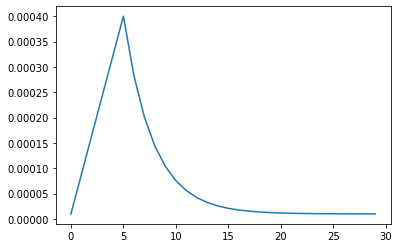

In [12]:
# Using an LR ramp up because fine-tuning a pre-trained model.
# Starting with a high LR would break the pre-trained weights.

LR_START = 0.00001
LR_MAX = 0.00005 * strategy.num_replicas_in_sync
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 5
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = .7

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

In [13]:
def get_efficientnet():
    with strategy.scope():
        efficient = efn.EfficientNetB5(
            input_shape = (IMAGE_SIZE[0][0], IMAGE_SIZE[0][1], 3),
            weights = 'noisy-student', #or imagenet
            include_top = False
        )
        #make trainable so we can fine-tune
        efficient.trainable = True
        model = tf.keras.Sequential([
            efficient,
            tf.keras.layers.GlobalAveragePooling2D(),
            #tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(104, activation = 'softmax',dtype = 'float32')
        ])
        model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['categorical_accuracy'])
    return model

In [14]:
%%time
# loading previously trained model to resume training(for 10+ epoch)

if RESUME_TRAINING:
    with strategy.scope():
        model1 = load_model('../input/train-efficientnet/Effnet_save.h5') 
else:
    model1 = get_efficientnet()
    
Checkpoint=tf.keras.callbacks.ModelCheckpoint(f"Effnet_30ep.h5", verbose=1, mode='max')

train_history0 = model1.fit(
    get_training_dataset(IMAGE_SIZE[0], mataug=True, cutmixup=True, do_aug=True), 
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    initial_epoch=20,
    callbacks=[lr_callback, Checkpoint],
)


Epoch 00021: LearningRateScheduler reducing learning rate to 1.1851548988877769e-05.
Epoch 21/30
275/275 [==============================] - ETA: 0s - categorical_accuracy: 0.8449 - loss: 0.8104
Epoch 00021: saving model to Effnet_30ep.h5
275/275 [==============================] - 427s 2s/step - categorical_accuracy: 0.8449 - loss: 0.8104 - lr: 1.1852e-05

Epoch 00022: LearningRateScheduler reducing learning rate to 1.1296084292214439e-05.
Epoch 22/30
275/275 [==============================] - ETA: 0s - categorical_accuracy: 0.8440 - loss: 0.8079
Epoch 00022: saving model to Effnet_30ep.h5
275/275 [==============================] - 420s 2s/step - categorical_accuracy: 0.8440 - loss: 0.8079 - lr: 1.1296e-05

Epoch 00023: LearningRateScheduler reducing learning rate to 1.0907259004550108e-05.
Epoch 23/30
275/275 [==============================] - ETA: 0s - categorical_accuracy: 0.8453 - loss: 0.8126
Epoch 00023: saving model to Effnet_30ep.h5
275/275 [==============================] - 42

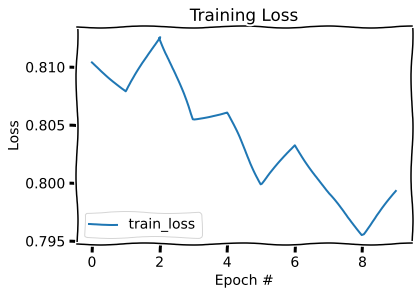

In [15]:
plot_training(train_history0)

Submission

In [16]:
def predict(model, img_size, n_iter):
    probs  = []
    data = get_test_dataset(ordered=True, IMG_SIZE=img_size)
    for i in range(n_iter):
        # Add TTA
        test_images_ds = data.map(lambda image, idnum: image)
        probs.append(model.predict(test_images_ds,verbose=0))
    return probs

In [17]:
print('Calculating predictions...')
probs1 = np.mean(predict(model1, IMAGE_SIZE[0], TTA_NUM), axis=0)
predictions = np.argmax(probs1, axis=-1)

print('Generating submission file...')
test_ds = get_test_dataset(ordered=True, IMG_SIZE=IMAGE_SIZE[0])
test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U') # all in one batch
np.savetxt('submission.csv', np.rec.fromarrays([test_ids, predictions]), fmt=['%s', '%d'], delimiter=',', header='id,label', comments='')


Calculating predictions...
Generating submission file...
